# Predicting housing sale prices with Iowa housing data
##### Includes data visualization, and linear regression models

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.linear_model import LinearRegression

pd.options.display.max_columns = 200
%matplotlib inline

In [24]:
data = pd.read_csv("C:\Data_files\AmesHousing.csv")
data.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,GasA,Fa,Y,SBrkr,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210,62,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,None,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,GasA,Ex,Y,SBrkr,2110,0,0,2110,1.0,0.0,2,1,3,1,Ex,8,Typ,2,TA,Attchd,1968.0,Fin,2.0,522.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [26]:
data.shape

(2930, 82)

## transform_features(df)
  - Removes columns with more than 5% missing data
  - Selects only numerical data
  - Calculates and adds house_age and years_since_remodeled columns
  - Drops columns that are not useful for a regression analysis and drops categorical columns

In [4]:
def transform_features(df):
    null_count = df.isnull().sum() #creates a series count of missing values for each column
    to_remove = null_count[(null_count > len(df)*0.05)] #selects columns with greater than 5% missing data
    cleaned = df.drop(columns = to_remove.index) #drops them
    
    #selecting columns with both less than 5% data missing and numerical data
    less_5_percent = null_count[(null_count < len(data)*.05)] #creates a series
    replace = [col for col in less_5_percent.index & df.select_dtypes('number').columns] #list of columns < 5% missing data and numerical data
    cleaned = cleaned.fillna(cleaned.median()) #replaces missing values with median
    
    #adding a years_since_remodeled column
    cleaned['years_since_remodeled'] = cleaned['Yr Sold'] - cleaned['Year Remod/Add'] #years since remodeling at time of sale
    cleaned['house_age'] = cleaned['Yr Sold'] - cleaned['Year Built']
    
    #drop non useful columns for regression
    non_useful = ['PID', 'Order','Garage Cars','Sale Type','Sale Condition','Misc Val', 'Yr Sold','Mo Sold','Year Remod/Add']
    cleaned = cleaned.drop(columns = non_useful)
    
    #drop categorical columns
    categorical_columns = cleaned.select_dtypes('object_').columns
    cleaned = cleaned.drop(columns = categorical_columns)
    
    return cleaned

In [5]:
def select_features(df, features = ['Gr Liv Area','SalePrice']):
    
    
    return df[features]

## train_and_test(data, k=10):
- Generates a linear regression model k times
- Performs cross validation k times and returns average RMSE

In [39]:
def train_and_test(data, k=10):
    '''
    Linear regression test for housing data.
    data : DataFrame
    k    : int, default = 10
    Performs k-folds cross validation automatically.
    Performs holdout validation at k=0; single cross validation at k=1
    Returns average RMSE for the regression
    '''
    
    half = int(len(data)/2)
    data = data.select_dtypes(include=['number'])
    features = data.columns.drop('SalePrice') #to avoid training on the target
    regr = LinearRegression()
    if k == 0 or k == 1:
        #holdout validation
        train = data[:half]
        test = data[half:]
        regr.fit(train[features], train['SalePrice'])
        prediction = regr.predict(test[features])
        rmse = np.sqrt(
                    mean_squared_error(prediction, test['SalePrice'])
                        )
        if k == 0:
            return rmse
        else:
            #simple cross validation
            train = data[half:] 
            test = data[:half]
            regr = LinearRegression().fit(train[features], train['SalePrice'])
            prediction = regr.predict(test[features])
            rmse_two = np.sqrt(
                            mean_squared_error(prediction, test['SalePrice'])
                                )
            return np.mean([rmse, rmse_two])
            
    else:
        #k-fold validation
        kf = KFold(n_splits=k, random_state=1, shuffle=True)
        rmses = []
        for train_index, test_index in kf.split(data):
            train = data.iloc[train_index]
            test = data.iloc[test_index]
            regr.fit(train[features], train['SalePrice'])
            prediction = regr.predict(test[features])
            rmse = np.sqrt(
                        mean_squared_error(prediction, test['SalePrice'])
                            )
            rmses.append(rmse)
        return np.mean(rmses)
        

In [40]:
#testing functions
test_model = transform_features(data)
print('RMSE:', 
      train_and_test(
    select_features(test_model), 10
                    )
     )

RMSE: 56337.726830275424


## Heatmap

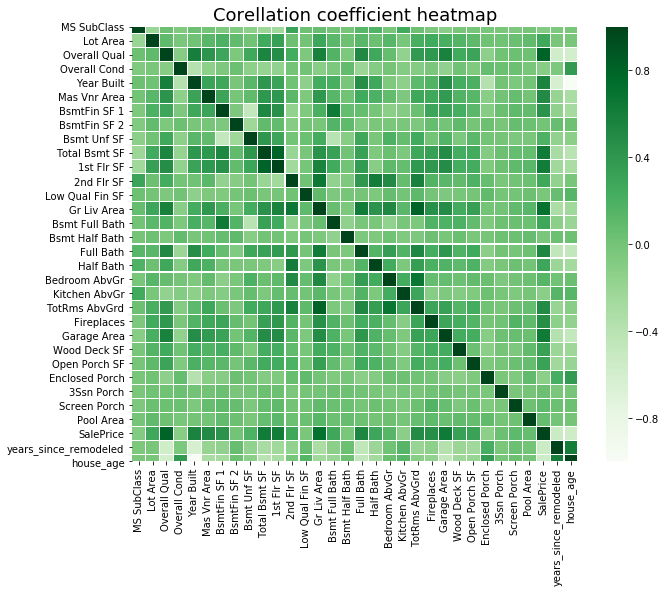

In [38]:
#should write these plots as functions
plt.subplots(figsize=(10,8))
plt.title("Corellation coefficient heatmap", size=18)
sns.heatmap(test_model.corr(), linewidths=0.1, cmap="Greens")

## Barplot
    Shows the features with the strongest correlation to SalePrice in the data.

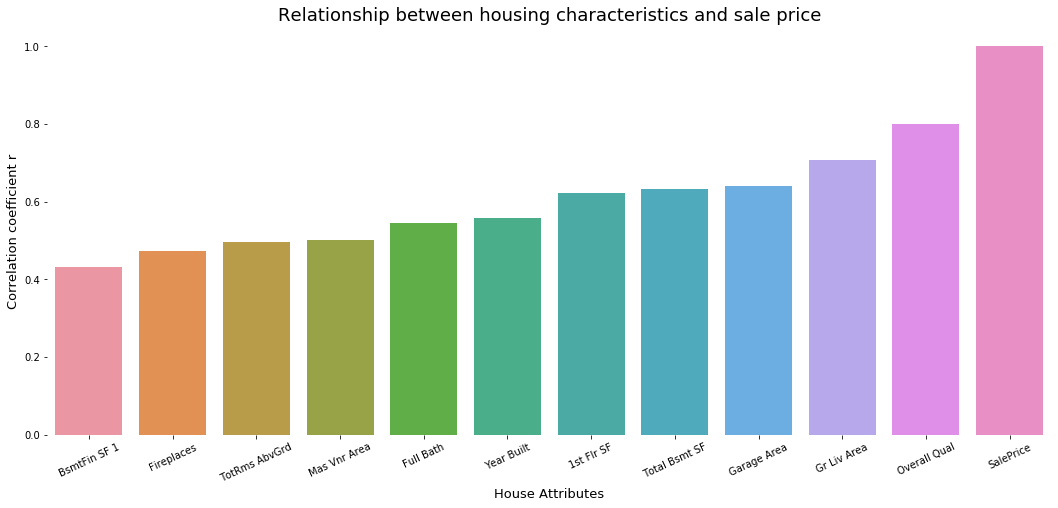

In [11]:
corrs = test_model.corr().sort_values('SalePrice',ascending=True)
labels = corrs.index
#removing values with a correlation coefficient less than 0.4 (arbitrary cutoff)
to_barplot = pd.DataFrame(corrs['SalePrice'], labels)
to_barplot = to_barplot[(to_barplot['SalePrice'] > 0.4)]

plt.subplots(figsize=(18,7.5))
sns.barplot(x=to_barplot.index, y='SalePrice', data=to_barplot)
plt.xticks(rotation=25)
plt.xlabel('House Attributes', size = 13)
plt.ylabel('Correlation coefficient r', size=13)
plt.title('Relationship between housing characteristics and sale price', size=18)
sns.despine(left=True, bottom=True)

In [12]:
to_barplot

,SalePrice
BsmtFin SF 1,0.432862
Fireplaces,0.474558
TotRms AbvGrd,0.495474
Mas Vnr Area,0.502196
Full Bath,0.545604
Year Built,0.558426
1st Flr SF,0.621676
Total Bsmt SF,0.632164
Garage Area,0.640381
Gr Liv Area,0.706780


In [ ]:
#find best attributes to generate the linear regression model
tests = {}
